In [1]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import mapclassify
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Geostatistics
import libpysal
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import libpysal as ps
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights
from pysal.model import spreg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error
from spreg import Probit

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

/Users/albertcortbanke/miniconda3/envs/msngdata/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/albertcortbanke/miniconda3/envs/msngdata/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/albe

In [2]:
import scipy
print(scipy.__version__)

1.7.3


In [3]:
import pymc3 as pm
import theano.tensor as tt

In [4]:
# Read the GeoParquet file without one-hot sampling
gdf_no_oh = gpd.read_parquet('gdf_no_ohe.parquet')

In [5]:
ef_score_distribution = gdf_no_oh['ef_score'].value_counts(normalize=True)
print(ef_score_distribution)

0    0.890419
1    0.109581
Name: ef_score, dtype: float64


In [6]:
# Renaming
gdf = gdf_no_oh

# Extract x and y from the geometry as separate features
gdf['x'] = gdf['geometry'].centroid.x
gdf['y'] = gdf['geometry'].centroid.y

# Select predictor variables and spatial covariates
predictor_vars = ['year', 'region', 'ef_government', 'x', 'y']

# Encode categorical variables
le = LabelEncoder()
gdf['region'] = le.fit_transform(gdf['region'])

# Set X and y
X = gdf[predictor_vars]
y = gdf['ef_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.9054441260744985
Confusion Matrix:
 [[628   0]
 [ 66   4]]


In [7]:
gdf_no_oh

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation,country_code,geometry,globalNorth,ef_score,hf_score,pf_expression_bti,pf_rol_civil,x,y
0,2020.0,Albania,2,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347...",1.0,0,0,0,0,20.068385,41.142285
1,2020.0,Algeria,4,10.0,9.687083,25.0,5.000000,10.000000,0.0,10.000000,...,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",0.0,0,0,0,0,2.632388,28.163239
2,2020.0,Angola,8,10.0,9.582498,25.0,7.500000,9.736578,5.0,9.971733,...,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...",0.0,0,0,0,0,17.544676,-12.295285
3,2020.0,Argentina,3,5.0,10.000000,0.0,7.500000,9.925379,2.0,10.000000,...,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...",0.0,0,0,0,0,-65.167727,-35.376436
4,2020.0,Armenia,0,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804...",1.0,0,0,0,1,44.946824,40.286620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Venezuela,3,10.0,10.000000,0.0,8.231718,10.000000,0.0,10.000000,...,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...",0.0,0,0,0,1,-66.169564,7.122449
3482,2000.0,Vietnam,7,10.0,10.000000,0.0,7.964260,10.000000,0.0,10.000000,...,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",0.0,0,0,0,1,106.301474,16.659256
3483,2000.0,Yemen,4,5.0,10.000000,0.0,7.044853,8.170079,19.0,7.932996,...,6.684552,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...",0.0,1,1,0,1,47.599591,15.905517
3484,2000.0,Zambia,8,10.0,10.000000,0.0,7.552838,10.000000,0.0,9.827262,...,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...",0.0,0,0,0,1,27.798249,-13.453019


In [8]:
gdf.region

0       2
1       4
2       8
3       3
4       0
       ..
3481    3
3482    7
3483    4
3484    8
3485    8
Name: region, Length: 3486, dtype: int64

In [9]:
w_knn = weights.KNN.from_dataframe(gdf_no_oh, k=4)
w_queen = weights.contiguity.Queen.from_dataframe(gdf_no_oh)

In [10]:
y_name = 'ef_score'
y = gdf_no_oh[y_name].values

x_names = ['pf_ss_disappearances_injuries',
       'pf_ss_disappearances_injuries_data', 'pf_ss_disappearances', 'pf_ss',
       'pf_expression_direct_killed', 'pf_expression_direct_killed_data',
       'pf_expression_direct_jailed', 'pf_expression_direct_jailed_data',
       'pf_expression_direct', 'pf_expression_cld', 'pf_identity_divorce',
       'pf_identity_fgm', 'ef_government_tax_income_data',
       'ef_government_tax_payroll_data', 'ef_government_soa', 'ef_government',
       'ef_legal_protection', 'ef_legal_military', 'ef_legal_integrity',
       'ef_legal_enforcement', 'ef_legal_regulatory', 'ef_legal_police',
       'ef_gender', 'ef_money_sd', 'ef_money_sd_data', 'ef_money_inflation']
x = np.array(gdf_no_oh[x_names])

In [11]:
ols = OLS(y = y, x = x, w = w_knn, name_y=y_name, name_x = x_names, 
        name_w="w_knn", name_ds='gdf_no_oh', 
        white_test=True, spat_diag=True, moran=True)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :   gdf_no_oh
Weights matrix      :       w_knn
Dependent Variable  :    ef_score                Number of Observations:        3486
Mean dependent var  :      0.1096                Number of Variables   :          27
S.D. dependent var  :      0.3124                Degrees of Freedom    :        3459
R-squared           :     -0.1718
Adjusted R-squared  :     -0.1806
Sum squared residual:     398.560                F-statistic           :     61.4866
Sigma-square        :       0.115                Prob(F-statistic)     :  6.823e-262
S.E. of regression  :       0.339                Log likelihood        :   -1166.457
Sigma-square ML     :       0.114                Akaike info criterion :    2386.914
S.E of regression ML:      0.3381                Schwarz criterion     :    2553.139

-----------------------------------------------------------------------------

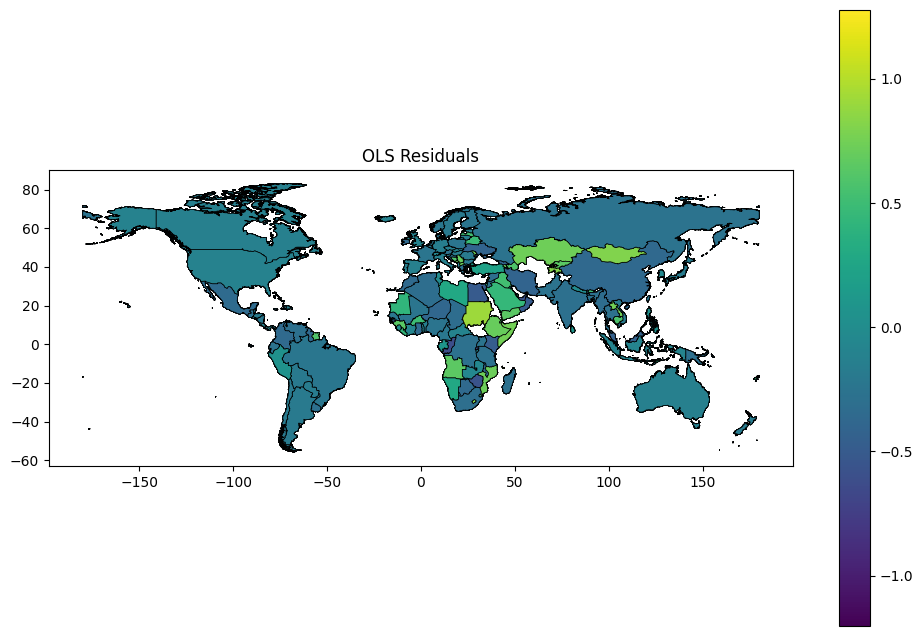

In [12]:
gdf_no_oh['ols_res'] = ols.u

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_no_oh.plot(column='ols_res', ax=ax, legend=True, cmap='viridis', edgecolor='black', linewidth=0.5)
ax.set_title('OLS Residuals')
plt.show()

### Bayesian Spatio-Temporal Interaction (BSTI) and  MGWR / GWR